In [11]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 20  # Frozen base training
EPOCHS_PHASE2 = 15  # Fine-tuning
NUM_CLASSES = 2  # appendicitis vs no appendicitis

# Your directory structure:
# images/
#   ├── appendicitis_images/
#   └── no_appendicitis_images/

model_save_dir = 'saved_models'
os.makedirs(model_save_dir, exist_ok=True)

print("Setup completed!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"Looking for images in: images/appendicitis_images/ and images/no_appendicitis_images/")

Setup completed!
TensorFlow version: 2.15.0
GPU available: []
Looking for images in: images/appendicitis_images/ and images/no_appendicitis_images/


In [12]:
print("--- 1. Data Preparation with Class Renaming ---")

import shutil

# Configuration
data_dir = 'images'
processed_data_dir = 'processed_data'
VALIDATION_SPLIT = 0.2

# Create processed data directory with clearer names
os.makedirs(processed_data_dir, exist_ok=True)
os.makedirs(os.path.join(processed_data_dir, 'has_appendicitis'), exist_ok=True)
os.makedirs(os.path.join(processed_data_dir, 'doesnt_have_appendicitis'), exist_ok=True)

# Map your directories to clearer names
source_mapping = {
    'appendicitis_images': 'has_appendicitis',
    'no_appendicitis_images': 'doesnt_have_appendicitis'
}

print("Creating symbolic links for clearer class names...")

for source_dir, target_dir in source_mapping.items():
    source_path = os.path.join(data_dir, source_dir)
    target_path = os.path.join(processed_data_dir, target_dir)
    
    if os.path.exists(source_path):
        # Remove existing link/directory if it exists
        if os.path.exists(target_path):
            if os.path.islink(target_path):
                os.unlink(target_path)
            else:
                shutil.rmtree(target_path)
        
        # Create symbolic link (or copy if on Windows and links don't work)
        try:
            os.symlink(os.path.abspath(source_path), target_path)
            print(f"  Linked: {source_dir} -> {target_dir}")
        except OSError:
            # Fallback: copy files if symbolic links don't work
            shutil.copytree(source_path, target_path)
            print(f"  Copied: {source_dir} -> {target_dir}")
    else:
        print(f"  Warning: {source_path} not found!")

# Now use the processed directory
data_dir = processed_data_dir

# Rest of the data preparation code (same as above)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Classes: {train_generator.class_indices}")

--- 1. Data Preparation with Class Renaming ---
Creating symbolic links for clearer class names...
  Linked: appendicitis_images -> has_appendicitis
  Linked: no_appendicitis_images -> doesnt_have_appendicitis
Found 1378 images belonging to 2 classes.
Found 343 images belonging to 2 classes.

Training samples: 1378
Validation samples: 343
Classes: {'doesnt_have_appendicitis': 0, 'has_appendicitis': 1}


In [15]:
print("--- 2. Model Creation ---")

# Create base model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
inputs = base_model.input
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile model for phase 1 (frozen base)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()

--- 2. Model Creation ---
Model architecture:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dropout_5 (D

In [16]:
print("--- 3. Phase 1: Training with Frozen Base ---")

# Callbacks for phase 1
callbacks_phase1 = [
    ModelCheckpoint(
        os.path.join(model_save_dir, 'model_frozen_base_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train phase 1
history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=callbacks_phase1,
    verbose=1
)

--- 3. Phase 1: Training with Frozen Base ---
Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.7765
Epoch 1: val_accuracy improved from -inf to 0.77843, saving model to saved_models/model_frozen_base_best.keras
44/44 [==============================] - 27s 532ms/step - loss: 0.5497 - accuracy: 0.7765 - val_loss: 0.5435 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.7779
Epoch 2: val_accuracy did not improve from 0.77843
44/44 [==============================] - 23s 514ms/step - loss: 0.5416 - accuracy: 0.7779 - val_loss: 0.5291 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.7779
Epoch 3: val_accuracy did not improve from 0.77843
44/44 [==============================] - 24s 542ms/step - loss: 0.5343 - accuracy: 0.7779 - val_loss: 0.5380 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 4/20
44/44 [======

In [17]:
print("--- 3.3 Saving Current Model State (End of Phase 1) ---")

# Save the model after the first training phase
model.save(os.path.join(model_save_dir, 'model_frozen_base_final.keras'))
print(f"Model saved at '{os.path.join(model_save_dir, 'model_frozen_base_final.keras')}'")
print(f"The best model (based on validation accuracy) was saved to '{os.path.join(model_save_dir, 'model_frozen_base_best.keras')}'")

# Display phase 1 results
phase1_val_acc = max(history_phase1.history['val_accuracy'])
phase1_val_loss = min(history_phase1.history['val_loss'])
print(f"Phase 1 - Best Validation Accuracy: {phase1_val_acc:.4f}")
print(f"Phase 1 - Best Validation Loss: {phase1_val_loss:.4f}")

--- 3.3 Saving Current Model State (End of Phase 1) ---
Model saved at 'saved_models/model_frozen_base_final.keras'
The best model (based on validation accuracy) was saved to 'saved_models/model_frozen_base_best.keras'
Phase 1 - Best Validation Accuracy: 0.7784
Phase 1 - Best Validation Loss: 0.5289


In [18]:
print("--- 4. Phase 2: Fine-tuning ---")

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) // 2

# Freeze the earlier layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning (using legacy optimizer)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),  # Legacy optimizer
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Fine-tuning from layer {fine_tune_at} onwards")
print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {sum([1 for layer in model.layers if layer.trainable])}")

--- 4. Phase 2: Fine-tuning ---
Fine-tuning from layer 119 onwards
Total layers: 7
Trainable layers: 6


In [20]:
# Callbacks for phase 2
callbacks_phase2 = [
    ModelCheckpoint(
        os.path.join(model_save_dir, 'model_finetuned_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

# Continue training with fine-tuning
history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=validation_generator,
    callbacks=callbacks_phase2,
    verbose=1
)

Epoch 1/15
44/44 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.7779
Epoch 1: val_accuracy improved from -inf to 0.77843, saving model to saved_models/model_finetuned_best.keras
44/44 [==============================] - 53s 1s/step - loss: 0.5396 - accuracy: 0.7779 - val_loss: 0.5292 - val_accuracy: 0.7784 - lr: 1.0000e-04
Epoch 2/15
44/44 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7779
Epoch 2: val_accuracy did not improve from 0.77843
44/44 [==============================] - 57s 1s/step - loss: 0.5393 - accuracy: 0.7779 - val_loss: 0.5295 - val_accuracy: 0.7784 - lr: 1.0000e-04
Epoch 3/15
44/44 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.7779
Epoch 3: val_accuracy did not improve from 0.77843
44/44 [==============================] - 52s 1s/step - loss: 0.5347 - accuracy: 0.7779 - val_loss: 0.5293 - val_accuracy: 0.7784 - lr: 1.0000e-04
Epoch 4/15
44/44 [==============================] - ETA: 0s - loss: 0

In [21]:
print("--- 5. Final Model Saving ---")

# Save final model
model.save(os.path.join(model_save_dir, 'appendicitis_model_final.keras'))
print(f"Final model saved at '{os.path.join(model_save_dir, 'appendicitis_model_final.keras')}'")

print("--- 6. Model Evaluation ---")

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Compare with Phase 1 results
print(f"\nComparison:")
print(f"Phase 1 Best Val Accuracy: {phase1_val_acc:.4f}")
print(f"Phase 2 Final Val Accuracy: {val_accuracy:.4f}")
print(f"Improvement: {val_accuracy - phase1_val_acc:.4f}")

--- 5. Final Model Saving ---
Final model saved at 'saved_models/appendicitis_model_final.keras'
--- 6. Model Evaluation ---
Final Validation Accuracy: 0.7784
Final Validation Loss: 0.5292

Comparison:
Phase 1 Best Val Accuracy: 0.7784
Phase 2 Final Val Accuracy: 0.7784
Improvement: 0.0000


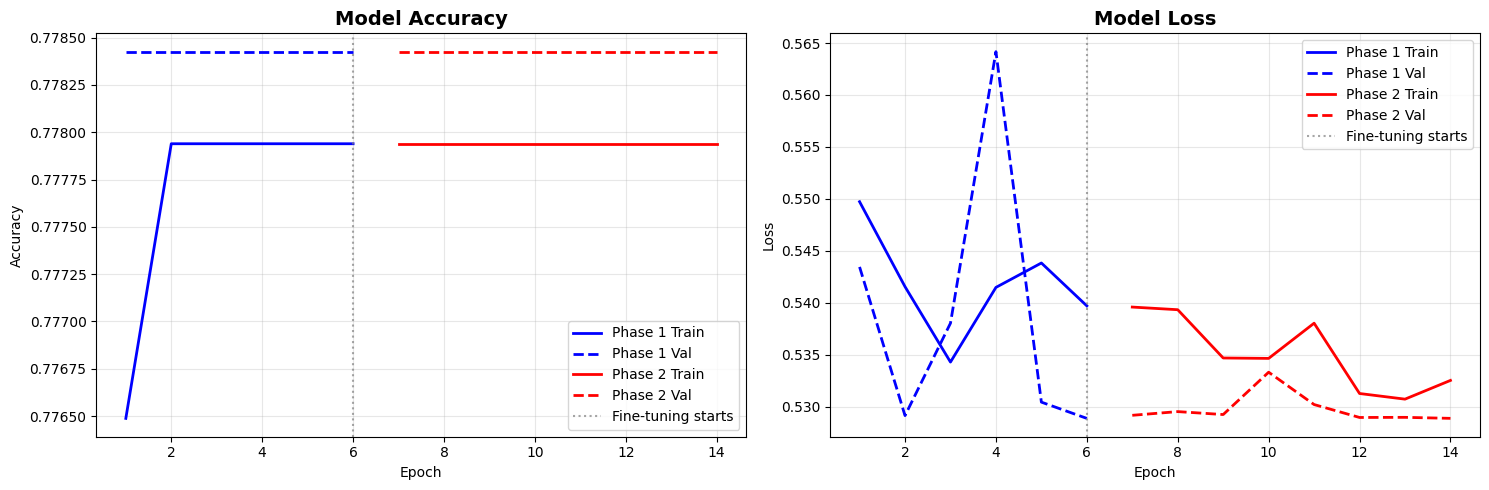

In [22]:
def plot_training_history(history1, history2):
    """Plot training history for both phases"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Combine histories
    epochs1 = range(1, len(history1.history['accuracy']) + 1)
    epochs2 = range(len(history1.history['accuracy']) + 1, 
                   len(history1.history['accuracy']) + len(history2.history['accuracy']) + 1)
    
    # Accuracy plot
    ax1.plot(epochs1, history1.history['accuracy'], 'b-', label='Phase 1 Train', linewidth=2)
    ax1.plot(epochs1, history1.history['val_accuracy'], 'b--', label='Phase 1 Val', linewidth=2)
    ax1.plot(epochs2, history2.history['accuracy'], 'r-', label='Phase 2 Train', linewidth=2)
    ax1.plot(epochs2, history2.history['val_accuracy'], 'r--', label='Phase 2 Val', linewidth=2)
    ax1.axvline(x=len(epochs1), color='gray', linestyle=':', alpha=0.7, label='Fine-tuning starts')
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(epochs1, history1.history['loss'], 'b-', label='Phase 1 Train', linewidth=2)
    ax2.plot(epochs1, history1.history['val_loss'], 'b--', label='Phase 1 Val', linewidth=2)
    ax2.plot(epochs2, history2.history['loss'], 'r-', label='Phase 2 Train', linewidth=2)
    ax2.plot(epochs2, history2.history['val_loss'], 'r--', label='Phase 2 Val', linewidth=2)
    ax2.axvline(x=len(epochs1), color='gray', linestyle=':', alpha=0.7, label='Fine-tuning starts')
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(model_save_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Plot the training history
plot_training_history(history_phase1, history_phase2)

In [23]:
def predict_appendicitis(image_path, model_path=None):
    """
    Predict if an ultrasound scan shows appendicitis
    
    Args:
        image_path: Path to the ultrasound image
        model_path: Path to the trained model (optional)
    
    Returns:
        predicted_class: 'appendicitis_images' or 'no_appendicitis_images'
        confidence: Confidence score (0-1)
    """
    if model_path is None:
        model_path = os.path.join(model_save_dir, 'appendicitis_model_final.keras')
    
    # Load model
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    prediction = loaded_model.predict(img_array, verbose=0)
    
    # Get class names (adjust based on your class_indices)
    class_names = ['appendicitis_image', 'no_appendicitis_images']
    
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    return predicted_class, confidence, prediction[0]

def display_prediction(image_path):
    """Display image with prediction"""
    result, confidence, probabilities = predict_appendicitis(image_path)
    
    # Display image
    img = plt.imread(image_path)
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Ultrasound Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    classes = ['No Appendicitis', 'Has Appendicitis']
    colors = ['green' if result == 'no_appendicitis_images' else 'red', 
              'red' if result == 'appendicitis_images' else 'green']
    
    bars = plt.bar(classes, probabilities, color=colors, alpha=0.7)
    plt.title(f'Prediction: {result.replace("_", " ").title()}\nConfidence: {confidence:.2%}')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, prob in zip(bars, probabilities):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return result, confidence

print("Prediction functions defined!")
print("\nUsage examples:")
print("# For simple prediction:")
print("result, confidence, probs = predict_appendicitis('path/to/image.jpg')")
print("\n# For prediction with visualization:")
print("result, confidence = display_prediction('path/to/image.jpg')")

Prediction functions defined!

Usage examples:
# For simple prediction:
result, confidence, probs = predict_appendicitis('path/to/image.jpg')

# For prediction with visualization:
result, confidence = display_prediction('path/to/image.jpg')


In [ ]:
print("🎉 TRAINING COMPLETED! 🎉")
print("="*50)
print(f"📁 Models saved in: {model_save_dir}")
print(f"📊 Final validation accuracy: {val_accuracy:.4f}")
print(f"📈 Training history plot saved as: training_history.png")

print("\n📋 Available Models:")
for file in os.listdir(model_save_dir):
    if file.endswith('.keras'):
        print(f"  • {file}")

print("\n🔍 Next Steps:")
print("1. Test your model with new ultrasound images")
print("2. Use display_prediction() to visualize results")
print("3. Consider collecting more data if accuracy is low")
print("4. Validate results with medical professionals")

print("\n⚠️  Important Notes:")
print("• This model is for research/educational purposes only")
print("• Always consult medical professionals for diagnosis")
print("• Consider class imbalance in your dataset")
print("• Validate on independent test set before deployment")